In [100]:
import librosa
import numpy as np
from IPython.display import Audio
import matplotlib.pyplot as plt
import os
import pandas as pd

In [122]:
def fig_ax(figsize=(15, 5), dpi=150):
    """Return a (matplotlib) figure and ax objects with given size."""
    return plt.subplots(figsize=figsize, dpi=dpi)

In [123]:
audio_folder = "../../../audio/selected/"
audio_files = os.listdir(audio_folder)

In [124]:
audio_files

['Frank Sinatra   I Love You Baby.mp3',
 'Europe - The Final Countdown (Official Video).mp3',
 'Nathan Evans Wellerman Phav Deliriouz Hardstyle Bootleg HQ Videoclip.mp3',
 'Flo Rida - Wild Ones ft. Sia [Official Video].mp3',
 'Ne Yo Beautiful Monster Lyrics.mp3',
 'Break Your Heart.mp3',
 'DJ Antoine vs Timati feat. Kalenna - Welcome to St. Tropez (DJ Antoine vs Mad Mark Remix) [Lyrics].mp3',
 'Edward Maya - Stereo Love (Official Video).mp3',
 'Gabry Ponte  Giulia.mp3',
 'Cascada - Everytime We Touch (Official Video).mp3',
 'QUEVEDO  BZRP Music Sessions #52.mp3',
 'Pitbull - Give Me Everything ft. Ne-Yo, Afrojack, Nayer.mp3',
 'Gigi D Agostino L Amour Toujours 8D AUDIO.mp3',
 'Usher - More (RedOne Jimmy Joker Official Remix).mp3',
 "He's a Pirate.mp3",
 'Chris Brown - Forever (Jesse Bloch Remix).mp3',
 'Jennifer Lopez - On The Floor ft. Pitbull.mp3',
 'The Chainsmokers Closer Lyrics Video.mp3',
 'Eminem - Love The Way You Lie ft. Rihanna.mp3',
 'Imagine Dragons - Natural.mp3',
 'Pitbul

In [223]:
file_audio = audio_files[22]
file_audio

'In my head LYRICS Jason Derulo.mp3'

In [224]:
Audio(audio_folder+file_audio)

In [225]:
signal, sr = librosa.load(audio_folder+file_audio)
duration = librosa.get_duration(y=signal, sr=sr)

In [226]:
def getBoundaries(y,sr,B):
    chroma = librosa.feature.chroma_cqt(y=y, sr=sr)
    bounds = librosa.segment.agglomerative(chroma, B)
    bound_times = librosa.frames_to_time(bounds, sr=sr)
    return bound_times

In [227]:
bound_number = int(duration/30)
bound_number

6

In [228]:
bound_times = getBoundaries(signal,sr,bound_number)

In [229]:
def seconds_to_minutes_and_seconds(seconds):
    minutes = int(seconds // 60)
    seconds = int(seconds % 60)
    return f"{minutes:02d}:{seconds:02d}"

In [230]:
[seconds_to_minutes_and_seconds(value) for value in bound_times]

['00:00', '00:06', '02:18', '03:13', '03:18', '03:23']

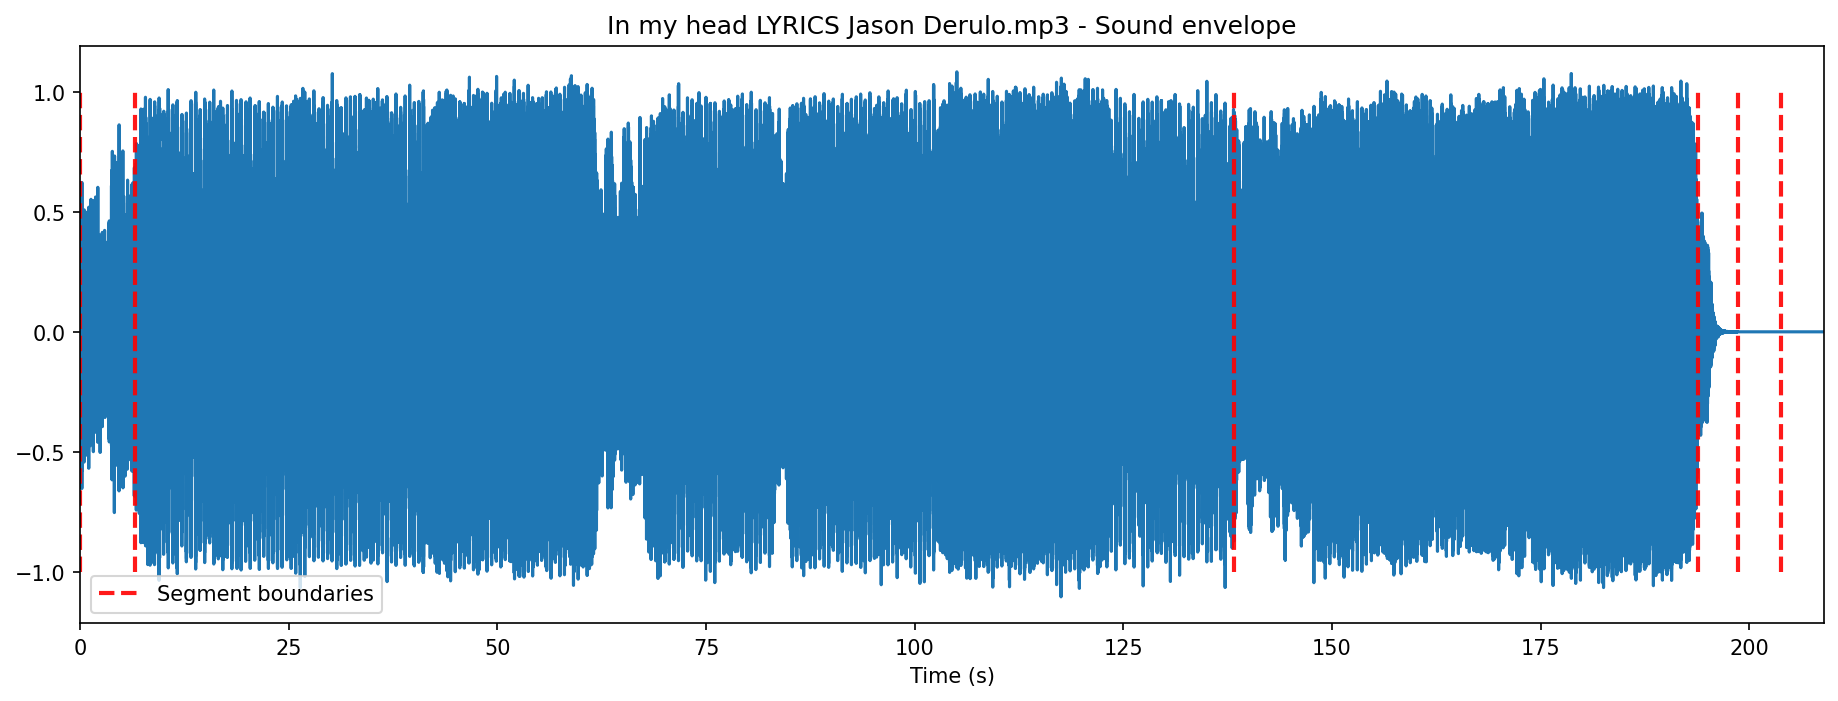

In [231]:
fig, ax = fig_ax()

ax.plot(np.arange(signal.size) / sr, signal)
ax.set_xlim(0, signal.size / sr)
ax.set_xlabel("Time (s)")

ax.vlines(bound_times, -1, 1, color='red', linestyle='--',
          linewidth=2, alpha=0.9, label='Segment boundaries')
ax.label_outer()
ax.legend()
_ = ax.set(title=file_audio+" - Sound envelope")

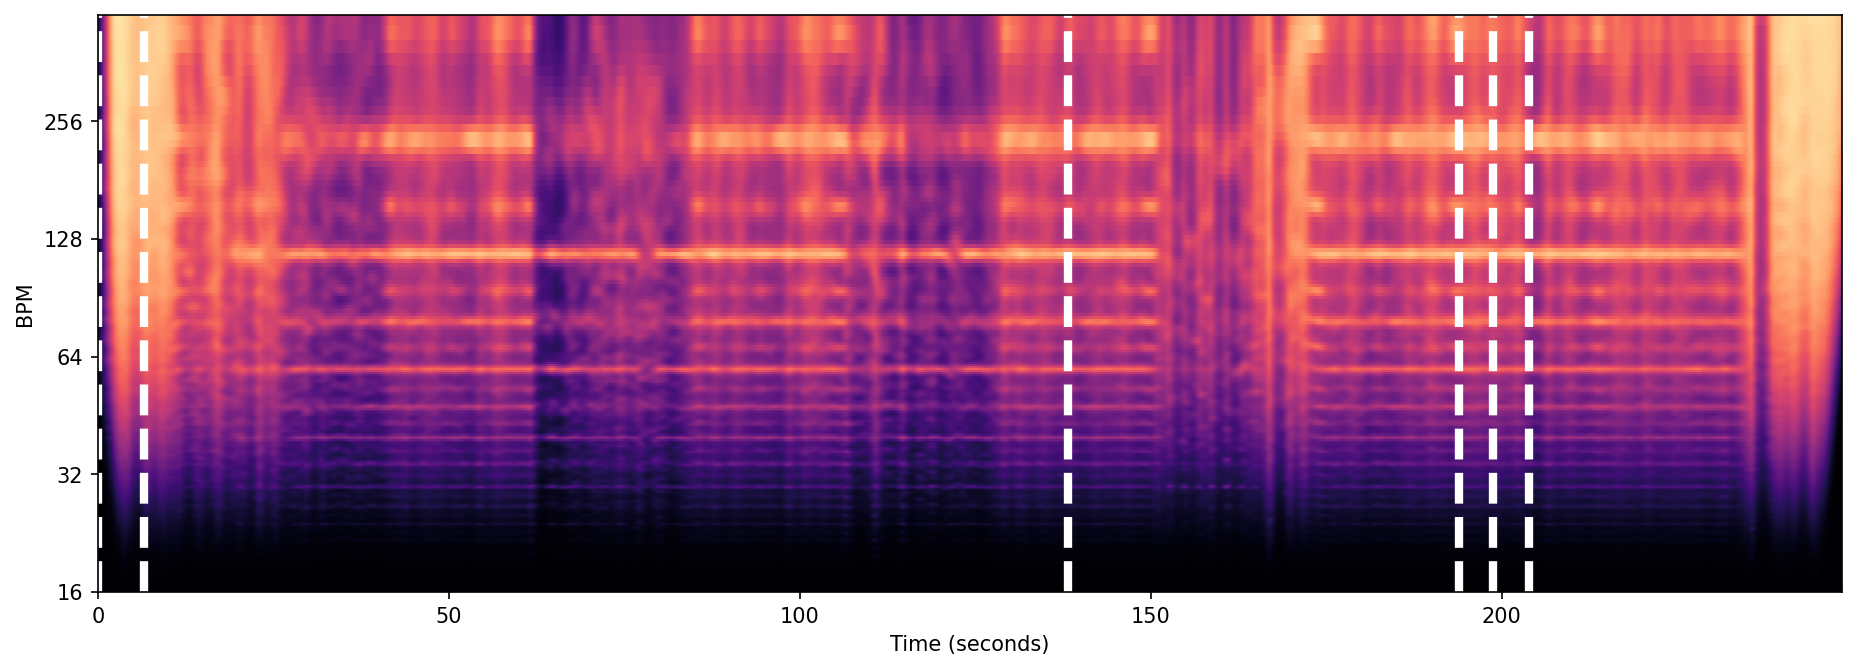

In [232]:
# Displaying results
fig, ax = fig_ax()
_ = librosa.display.specshow(
    tempogram,
    ax=ax,
    x_axis="s",
    y_axis="tempo",
    hop_length=hop_length_tempo,
    sr=sr,
)

for b in bound_times:
    ax.axvline(b, ls="--", color="white", lw=4)

In [233]:
bound_times = np.append(bound_times,duration)

In [234]:
avg_intensity = np.sqrt(np.mean(np.square(signal)))  
avg_intensity

0.28446686

In [235]:
def defineFlowType(limit_values,bound_intensity):
    delta = limit_values[-1] - limit_values[0]
    ratio = delta/bound_intensity
    if ratio>0.1:
        return 'CLIMAX'
    elif ratio<-0.1:
        return 'COOLDOWN'
    return 'STABLE'

In [236]:
def getBoundariesInfo(y, B, SUBS = 5, S = 1.0):
    
    # S = The number of seconds for each sub-boundary
    # SUBS = The number of sub-boundaries to consider

    # Initialize lists to store the volumes within each boundary and the volumes of the sub-boundaries
    intensity_in_boundaries = []
    
    
    for i in range(len(B) - 1):
        start_time = B[i]
        end_time = B[i + 1]
    
        # Convert time boundaries to sample indices
        start_sample = librosa.time_to_samples(start_time, sr=sr)
        end_sample = librosa.time_to_samples(end_time, sr=sr)
    
        # Extract values within the current boundary
        values_in_range = y[start_sample:end_sample]
    
        # Calculate the RMSE (root mean square energy) of values within the boundary
        rmse_in_range = np.sqrt(np.mean(np.square(values_in_range)))    
    
        # Generate starting sub-boundaries
        startSubs = [start_time + x * S for x in range(SUBS)]
        
        # Generate ending sub-boundaries
        endSubs = [end_time - (SUBS - x * S) for x in range(SUBS)]
    

        intensity_in_sub_boundaries_start = []
        # Calculate the RMSE for the sub-boundaries within the current main boundary
        for j in range(len(startSubs)-1):
            sub_start_sample = librosa.time_to_samples(startSubs[j], sr=sr)
            sub_end_sample = librosa.time_to_samples(startSubs[j+1], sr=sr)
            values_in_sub_range = y[sub_start_sample:sub_end_sample]
            rmse_in_sub_range = np.sqrt(np.mean(np.square(values_in_sub_range)))
            intensity_in_sub_boundaries_start.append(rmse_in_sub_range)

        intensity_in_sub_boundaries_end = []
        # Calculate the RMSE for the sub-boundaries within the current main boundary
        for j in range(len(endSubs)-1):
            sub_start_sample = librosa.time_to_samples(endSubs[j], sr=sr)
            sub_end_sample = librosa.time_to_samples(endSubs[j+1], sr=sr)
            values_in_sub_range = y[sub_start_sample:sub_end_sample]
            rmse_in_sub_range = np.sqrt(np.mean(np.square(values_in_sub_range)))
            intensity_in_sub_boundaries_end.append(rmse_in_sub_range)
        
        intensity_in_boundaries.append({
            'intensity': rmse_in_range,
            'start':intensity_in_sub_boundaries_start,
            'end':intensity_in_sub_boundaries_end,
            'start_delta':intensity_in_sub_boundaries_start[-1]-intensity_in_sub_boundaries_start[0],
            'end_delta':intensity_in_sub_boundaries_end[-1]-intensity_in_sub_boundaries_end[0],
            'flow_start': defineFlowType(intensity_in_sub_boundaries_start,rmse_in_range),
            'flow_end': defineFlowType(intensity_in_sub_boundaries_end,rmse_in_range),            
        })

    max_intensity = np.max([x['intensity'] for x in intensity_in_boundaries])
    min_intensity = np.min([x['intensity'] for x in intensity_in_boundaries])
    for item in intensity_in_boundaries:
        if item['intensity'] == max_intensity:
            item['energy']='HIGH'
        elif item['intensity'] == min_intensity:
            item['energy']='LOW'
        else:
            item['energy']='AVG'
    # intensity_in_boundaries contains the RMSE values within each specified boundary
    # intensity_in_sub_boundaries contains the RMSE values of the sub-boundaries
    return intensity_in_boundaries

In [237]:
boundaries_info = getBoundariesInfo(signal,bound_times,5,1)
boundaries_info

/var/folders/_8/tb5f_d7d4sb_w3qlpk0v2dkm0000gn/T/ipykernel_96841/3371319205.py:3: RuntimeWarning: invalid value encountered in scalar divide
  ratio = delta/bound_intensity


[{'intensity': 0.1214826,
  'start': [0.07306169, 0.080461495, 0.06768663, 0.10070191],
  'end': [0.06805031, 0.072357245, 0.1540427, 0.17345966],
  'start_delta': 0.027640224,
  'end_delta': 0.105409354,
  'flow_start': 'CLIMAX',
  'flow_end': 'CLIMAX',
  'energy': 'AVG'},
 {'intensity': 0.28834435,
  'start': [0.23048367, 0.26623803, 0.37599745, 0.23347868],
  'end': [0.23249197, 0.2725165, 0.2884798, 0.27642575],
  'start_delta': 0.0029950142,
  'end_delta': 0.04393378,
  'flow_start': 'STABLE',
  'flow_end': 'CLIMAX',
  'energy': 'AVG'},
 {'intensity': 0.32395026,
  'start': [0.24991594, 0.24591054, 0.23539856, 0.22394867],
  'end': [0.38573092, 0.33907884, 0.3508864, 0.37521917],
  'start_delta': -0.02596727,
  'end_delta': -0.010511756,
  'flow_start': 'STABLE',
  'flow_end': 'STABLE',
  'energy': 'HIGH'},
 {'intensity': 0.07235176,
  'start': [0.13794915, 0.077203356, 0.006986099, 0.0006553334],
  'end': [0.14524297, 0.09664323, 0.012858255, 0.0010386001],
  'start_delta': -0.13

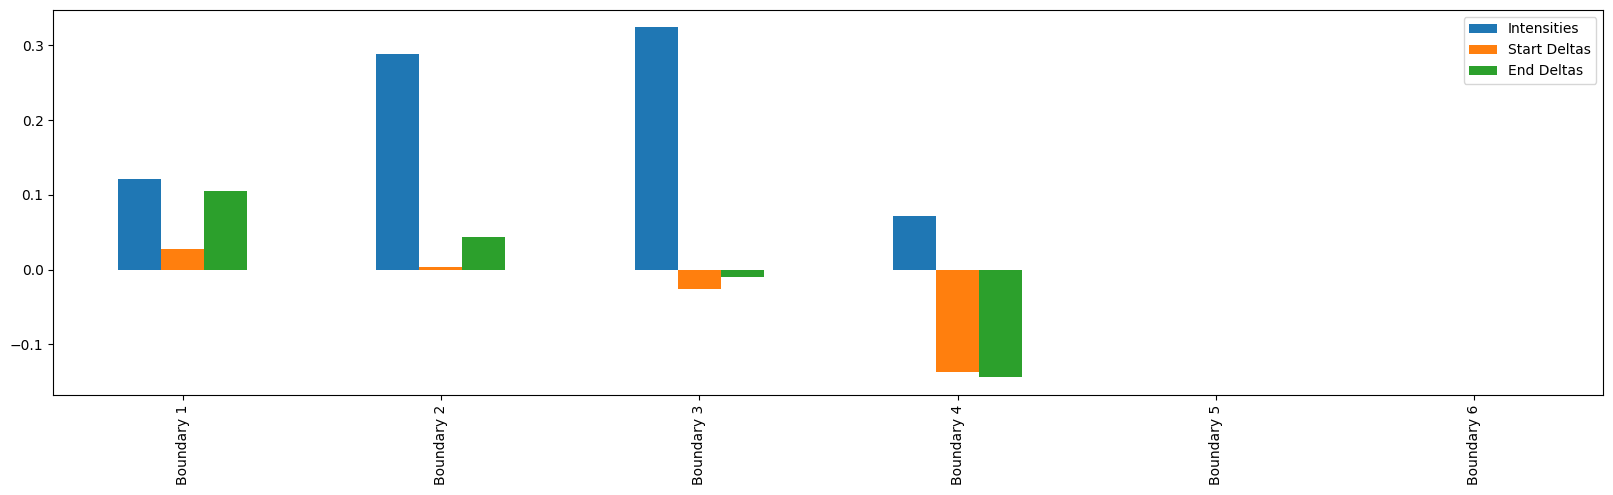

In [238]:
boundaries_intensities = [value['intensity'] for value in boundaries_info]
start_deltas = [value['start_delta'] for value in boundaries_info]
end_deltas = [value['end_delta'] for value in boundaries_info]
# Create an array of labels for the x-axis (optional)
labels = [f'Boundary {i+1}' for i in range(len(boundaries_intensities))]
data = {'Intensities': boundaries_intensities,
        'Start Deltas': start_deltas,
       'End Deltas': end_deltas}
df = pd.DataFrame(data,columns=['Intensities','Start Deltas','End Deltas'], index = labels)

df.plot.bar()
plt.show()

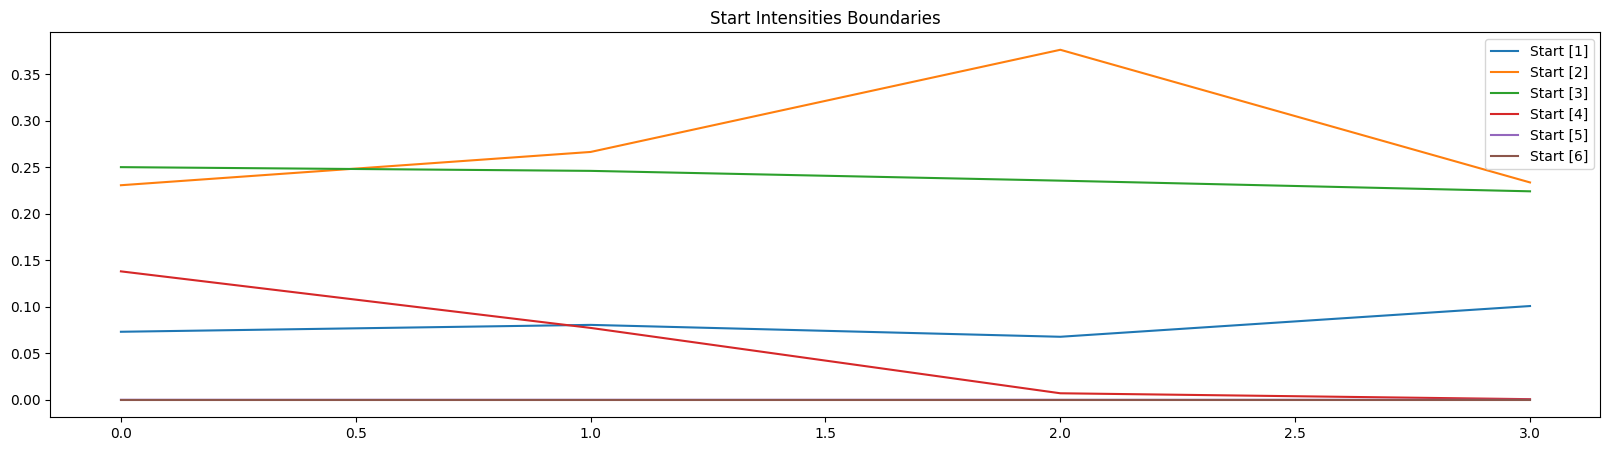

In [239]:
fig, ax = plt.subplots(sharex=True)
ax.set(title='Start Intensities Boundaries')
for i in range(len(boundaries_info)):
    intensity = boundaries_info[i]
    ax.plot(intensity['start'], label='Start [{}]'.format(i+1))
ax.label_outer()
ax.legend()

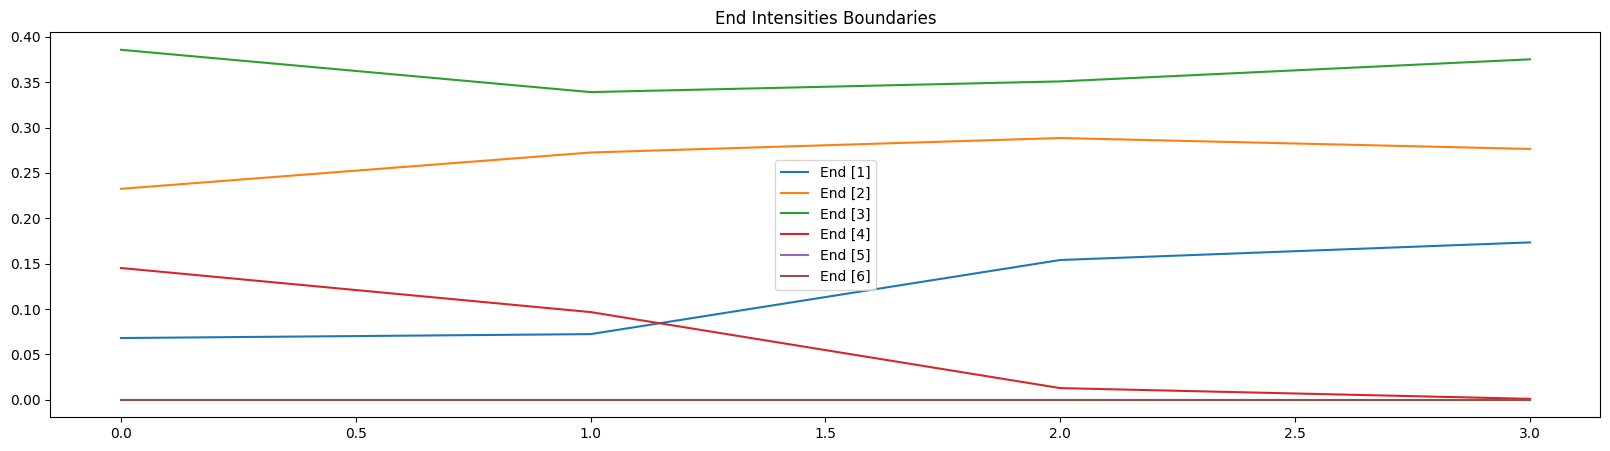

In [240]:
fig, ax = plt.subplots(sharex=True)
ax.set(title='End Intensities Boundaries')
for i in range(len(boundaries_info)):
    intensity = boundaries_info[i]
    ax.plot(intensity['end'], label='End [{}]'.format(i+1))
ax.label_outer()
ax.legend()

## Extract Boundary Type

In [244]:
for info in boundaries_info:
    print(info['energy'],info['flow_start'],info['flow_end'])

AVG CLIMAX CLIMAX
AVG STABLE CLIMAX
HIGH STABLE STABLE
AVG COOLDOWN COOLDOWN
AVG COOLDOWN STABLE
LOW STABLE STABLE
